Everything here is a minor tweak from the lecture on decision trees. Primary motivation is to forecast energy generated using other lagged variables.

# Ensemble Learning
- problem: trees tend to overfit data (i.e., high variance predictors albeit with low bias)
 - Can correct for high variance by using shallow trees (depth 3 to 5).    - But this lacks accuracy, so we should use many different trees and aggregate the results.
   - Bagging (bootstrap aggregation) on the data
     - sample from traning data with replacement
     - combine the data by taking the average (regression) or by voting (class)
     - these can be deep trees
     - potential problem: every tree has the same top node.
     - solution: restrict each tree to a random subset of the predictors. This is called a **random forest**.
   - Boosting: make a tree then fit a tree to the residuals and repeat
       - reduces bias
- how many trees? how deep? how many predictors? All soft questions called **hyperparameters**.
- loss function
- pruning: taking out nodes and refitting?

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz # might need to install -- need *both* python and system
# so use Anaconda (or pip) to install graphviz, and also https://graphviz.org/download/
# this was a non-trivial install on Mac (depends on Xcode command-line tools)
# `pip install graphviz` and `brew install graphviz`
import datetime as dt

%matplotlib inline

# 8.3.1 Fitting Classification Trees

The `sklearn` library has a lot of useful tools for constructing classification and regression trees:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

Train/test model on data up to 2017. Will test model on 2018/2019 later.

# TO DO: Import weather data
# TO DO: Break up data into 5-year chunks

**what's a reasonable average**

In [3]:
df = pd.read_csv("../../Data/1999_2021/aggragate_daily_data_2000to2020.csv", index_col = "date")
        .drop(labels = "Unnamed: 0", axis = 1)
df_2017 = df.loc['2000-01-01':'2017-12-31'].copy()
avg = df['energy_generated'].mean()                    #avg is average of energy_generated from 2000 to present
df_2017['high'] = df_2017.energy_generated.map(lambda x: 1 if x > avg else 0) 

Adding 7 day, 14 day, 30 day, 90 day lags to all variables except energy_generated.

In [125]:
df_2017_lagged = df_2017.copy()

for i in [7,14,30]:    #this is so UGLY I wish I knew how to code :(
    df_2017_lagged[['energy_charge_' + str(i)]] = df_2017_lagged.energy_charge.shift(-i)
    df_2017_lagged[['influent_flow_' + str(i)]] = df_2017_lagged.influent_flow.shift(-i)
    df_2017_lagged[['volume_used_' + str(i)]] = df_2017_lagged.volume_used.shift(-i)
    df_2017_lagged[['poured_flow_' + str(i)]] = df_2017_lagged.poured_flow.shift(-i)
    df_2017_lagged[['water_level_' + str(i)]] = df_2017_lagged.water_level.shift(-i)
    df_2017_lagged[['energy_stored_' + str(i)]] = df_2017_lagged.energy_stored.shift(-i)
    df_2017_lagged[['maximum_demand_' + str(i)]] = df_2017_lagged.maximum_demand.shift(-i)
    df_2017_lagged[['energy_generated_' + str(i)]] = df_2017_lagged.maximum_demand.shift(-i)
    df_2017_lagged[['turbine_flow']] = df_2017_lagged.effluent_flow - df_2017_lagged.poured_flow
    df_2017_lagged[['turbine_flow_' + str(i)]] = df_2017_lagged.turbine_flow.shift(-i)
    
df_2017_lagged = df_2017_lagged.dropna()
df_2017_lagged

,energy_charge,effluent_flow,influent_flow,volume_used,poured_flow,water_level,energy_generated,energy_stored,maximum_demand,high,...,turbine_flow_14,energy_charge_30,influent_flow_30,volume_used_30,poured_flow_30,water_level_30,energy_stored_30,maximum_demand_30,energy_generated_30,turbine_flow_30
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,457.103900,226.12,185.42,20.84,0.0,443.08,0.721700,20346.6165,25253.000,0,...,481.12,613.328400,280.81,40.16,25.0,445.64,33196.8420,31115.00,31115.00,330.12
2000-01-02,465.552600,255.12,459.28,21.53,0.0,443.06,0.823800,20944.1655,26388.000,0,...,442.12,627.231000,329.29,40.08,25.0,445.61,33709.6530,31165.00,31165.00,329.03
2000-01-03,553.481900,263.12,885.74,23.63,0.0,443.16,0.833400,21915.0000,29633.000,0,...,453.12,629.214800,532.19,40.91,25.0,445.60,34380.2520,31543.00,31543.00,259.03
2000-01-04,581.477800,373.12,1011.04,25.78,0.0,443.46,1.215900,23301.4890,30230.000,0,...,409.12,634.175500,571.30,42.00,25.0,445.70,34998.9855,31976.00,31976.00,221.03
2000-01-05,595.390500,483.12,916.95,27.24,0.0,443.76,1.556100,24564.5235,30661.000,1,...,410.12,647.605000,465.98,42.77,15.0,445.83,35426.3280,31556.00,31556.00,224.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,929.632423,285.00,368.10,54.45,25.0,447.23,1.025869,27425.8920,44379.000,0,...,264.00,922.801379,388.18,53.06,25.0,447.08,32041.9215,42975.20,42975.20,281.00
2017-11-28,935.214587,519.00,380.69,53.99,24.0,447.18,1.892854,27523.0485,44133.258,1,...,283.00,924.872414,462.12,53.99,25.0,447.18,32334.8520,42459.92,42459.92,162.00
2017-11-29,907.429400,501.00,556.21,54.17,25.0,447.20,1.808158,27678.6450,42919.090,1,...,280.00,900.138832,425.53,54.36,24.0,447.22,32685.4920,41104.24,41104.24,291.00


We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter.

**what the heck is a good train size**

Comment: removed current effluent_flow because it's too correlated with energy_generated. If you want to drop a variable from the tree do it here

In [127]:
X = df_2017_lagged.drop(['energy_generated', 'high','effluent_flow','turbine_flow'], axis = 1)
y = df_2017_lagged.high
lst=[]

for k in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = k*.1, random_state = 0)
    for x in range(1,11):
        classification_tree_daily = DecisionTreeClassifier(max_depth = x)
        classification_tree_daily.fit(X_train, y_train)
        lst.append([x,k,classification_tree_daily.score(X_train, y_train)])


**comment**: Adding all lags on all variables at once makes the training score go down (was previously 0.99 with 30 lag on everything.)

From the resulting lst I arbitrarily chose train_size = 0.1, max_depth = 7

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

In [128]:
df_2017_lagged[['energy_generated','turbine_flow_7','energy_generated_7']].corr()

,energy_generated,turbine_flow_7,energy_generated_7
energy_generated,1.000000,0.645067,0.068104
turbine_flow_7,0.645067,1.000000,0.032273
energy_generated_7,0.068104,0.032273,1.000000


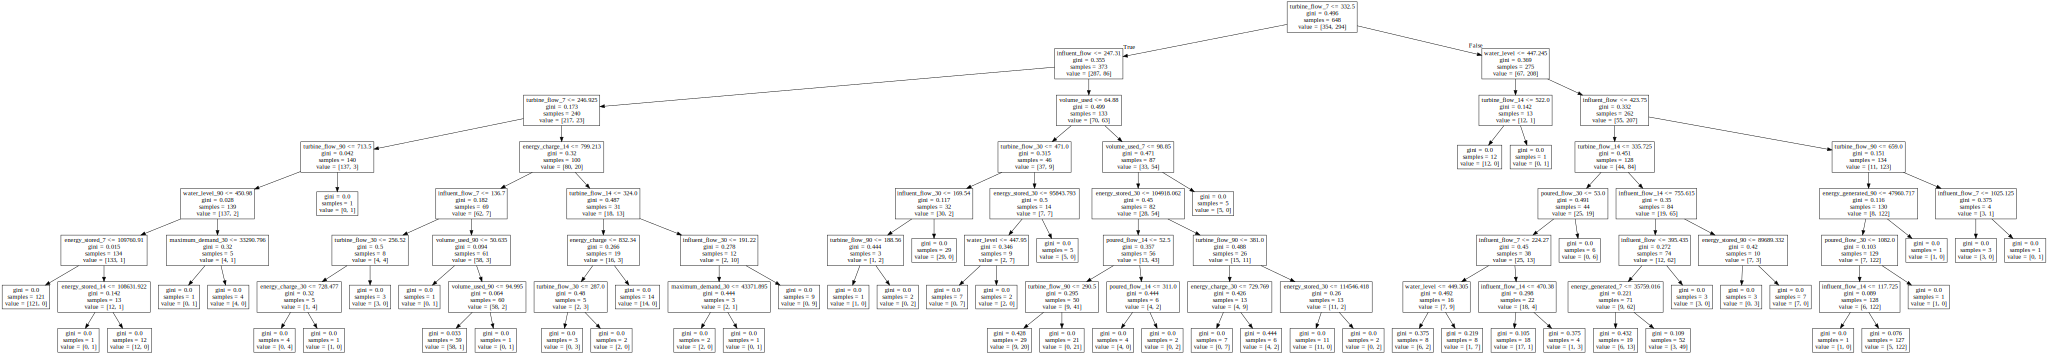

In [72]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow'], axis = 1)
y = df_2017_lagged.high

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .1, random_state = 0)
classification_tree_daily = DecisionTreeClassifier(max_depth = 7)
classification_tree_daily.fit(X_train, y_train)
export_graphviz(classification_tree_daily, 
                out_file = "tree.dot", 
                feature_names = X_train.columns)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [101]:
X = df_2017_lagged.drop(['energy_generated', 'high','effluent_flow'], axis = 1)
y = df_2017_lagged.high

for i in range(1,10):
    for j in range(1,11):
        for k in range(1,11):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = i*0.1, random_state = j)
            classification_tree_daily = DecisionTreeClassifier(max_depth = k)
            classification_tree_daily.fit(X_train, y_train)
            export_graphviz(classification_tree_daily, 
                        out_file = "train_" + str(i) + "_state_" + str(j) + "_depth_" + str(k) + ".dot", 
                        feature_names = X_train.columns)


'''with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)'''

KeyboardInterrupt: 

Max depth of 6, train_size of 0.8: effluent_flow, effluent_flow_7, influent_flow, effluent_flow_14 were the most important indicators in that order when all lags are included.


Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 7*0.1, random_state = 5)
classification_tree_daily = DecisionTreeClassifier(max_depth = 4)
classification_tree_daily.fit(X_train, y_train)

pred = classification_tree_daily.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)

       No  Yes
No   1045   18
Yes    28  854


# 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree**. 

In [111]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow','influent_flow', 'turbine_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_daily = DecisionTreeRegressor(max_depth = 2)
regr_tree_daily.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

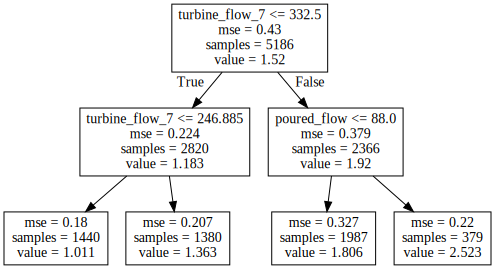

In [112]:
export_graphviz(regr_tree_daily, 
                out_file = "regr_tree.dot", 
                feature_names = X_train.columns)

with open("regr_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

max depth of 2 or 3: effluent_flow, effluent_flow_7,influent_flow,effluent_flow_14

0.2536188657097965

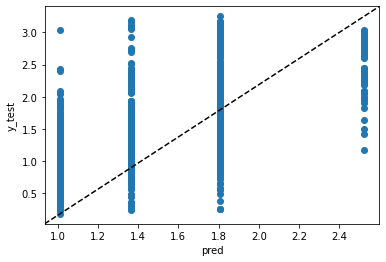

In [113]:
pred = regr_tree_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the regression tree is
35.4. The square root of the MSE is therefore around 5.95, indicating
that this model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb.
    
# 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [13]:
df_2017_lagged.shape

(6483, 42)

In [118]:
# Bagging: using all features
bagged_daily = RandomForestRegressor(max_features = 41, random_state = 1)
bagged_daily.fit(X_train, y_train)

RandomForestRegressor(max_features=41, random_state=1)

0.12092909326982833

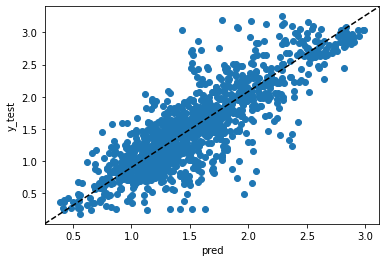

In [119]:
pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

In [48]:
lst = []

for j in range(1,11):
    for k in range(1,11):
        random_forest_daily = RandomForestRegressor(max_features = k, random_state = j)
        random_forest_daily.fit(X_train, y_train)
        pred = random_forest_daily.predict(X_test)
        Importance = pd.DataFrame({'Importance':random_forest_daily.feature_importances_*100}, 
                          index = X.columns)
        Importance = Importance[Importance['Importance'] > 7]
        lst.append([k, round(mean_squared_error(y_test, pred),5), Importance])

lst

[[1,
  0.12662,
  Empty DataFrame
  Columns: [Importance]
  Index: []],
 [2,
  0.11122,
                  Importance
  turbine_flow_7    10.25498],
 [3,
  0.11051,
                   Importance
  turbine_flow_7    11.490563
  turbine_flow_14    7.035854],
 [4,
  0.10646,
                   Importance
  turbine_flow_7    13.685353
  turbine_flow_14    7.995973],
 [5,
  0.10876,
                   Importance
  turbine_flow_7    16.475746
  turbine_flow_14    7.676342],
 [6,
  0.11091,
                   Importance
  poured_flow        7.595039
  turbine_flow_7    17.777568
  turbine_flow_14    8.257318],
 [7,
  0.10795,
                   Importance
  poured_flow        7.805895
  turbine_flow_7    18.284617
  turbine_flow_14    8.550022],
 [8,
  0.10894,
                   Importance
  poured_flow        7.443531
  turbine_flow_7    19.962743
  turbine_flow_14    8.336594],
 [9,
  0.10992,
                   Importance
  poured_flow        8.143271
  turbine_flow_7    22.125354
  turbin

turbine_flow_7 is the most important variable (after turbine_flow and effluent_flow). Has a correlation of 0.6814313 with energy_generated. Interesting because it shows that even with a little bit of time lag, we have an ok indicator of what future energy generation will be. 

In [120]:
Importance = pd.DataFrame({'Importance':random_forest_daily.feature_importances_*100}, 
                          index = X.columns).sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = False)


ValueError: Shape of passed values is (38, 1), indices imply (42, 1)

In [ ]:
Importance.plot(kind = 'barh', color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [121]:
boosted_daily = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.2, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_daily.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

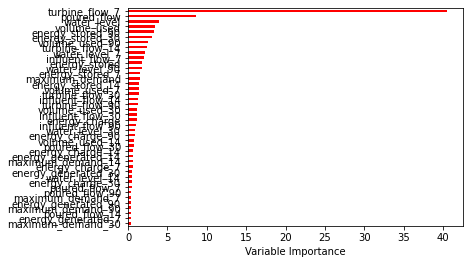

In [122]:
feature_importance = boosted_daily.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [123]:
mean_squared_error(y_test, boosted_daily.predict(X_test))

0.1053666402028988

If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [124]:
boosted_daily2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_daily2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_daily2.predict(X_test))

0.1053666402028988

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$.

To get credit for this lab, post your responses to the following questions:
 - What's one real-world scenario where you might try using Bagging?
 - What's one real-world scenario where you might try using Random Forests?
 - What's one real-world scenario where you might try using Boosting?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=264671